In [1]:
!pip install tensorflow smogn

In [2]:
# Import necessary libraries
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# For preprocessing
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split

# For handling imbalanced data
from imblearn.over_sampling import SMOTE

# For LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# For XGBoost
from xgboost import XGBRegressor

# For evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [4]:
# Load datasets
assessments = pd.read_csv('/content/drive/MyDrive/OULAD-anonymisedData/assessments.csv')
student_assessment = pd.read_csv('/content/drive/MyDrive/OULAD-anonymisedData/studentAssessment.csv')
student_info = pd.read_csv('/content/drive/MyDrive/OULAD-anonymisedData/studentInfo.csv')
vle = pd.read_csv('/content/drive/MyDrive/OULAD-anonymisedData/vle.csv')

# student vele
# chunk_list = []

# chunk_size = 9000
# for chunk in pd.read_csv(
#     '/content/drive/MyDrive/OULAD-anonymisedData/studentVle.csv',
#     engine='python',
#     chunksize=chunk_size,
#     on_bad_lines='skip'
# ):
#     chunk_list.append(chunk)

# student_vle = pd.concat(chunk_list)


In [5]:
# Initialize a counter for bad lines
bad_line_count = 0

# Define the bad line handler function
def bad_line_handler(line, line_number):
    global bad_line_count
    bad_line_count += 1
    print(f"Skipping line {line_number}: {line}")
    return None

# Read the CSV file using the custom bad line handler
student_vle = pd.read_csv(
    '/content/drive/MyDrive/OULAD-anonymisedData/studentVle.csv',
    engine='python',
    on_bad_lines=bad_line_handler
)

# Display the number of bad lines skipped
print(f'Number of bad lines skipped: {bad_line_count}')

Number of bad lines skipped: 0


In [6]:
# Handle missing values in 'score' by filling with mean
mean_score = student_assessment['score'].mean()
student_assessment['score'] = student_assessment['score'].fillna(mean_score)

In [7]:
print(f"Columns in student_assessment: {student_assessment.columns}")
print(f"Columns in assessments: {assessments.columns}")
print(f"Columns in student_info: {student_info.columns}")
print(f"Columns in vle: {vle.columns}")
print(f"Columns in student_vle: {student_vle.columns}")

Columns in student_assessment: Index(['id_assessment', 'id_student', 'date_submitted', 'is_banked', 'score'], dtype='object')
Columns in assessments: Index(['code_module', 'code_presentation', 'id_assessment', 'assessment_type',
       'date', 'weight'],
      dtype='object')
Columns in student_info: Index(['code_module', 'code_presentation', 'id_student', 'gender', 'region',
       'highest_education', 'imd_band', 'age_band', 'num_of_prev_attempts',
       'studied_credits', 'disability', 'final_result'],
      dtype='object')
Columns in vle: Index(['id_site', 'code_module', 'code_presentation', 'activity_type',
       'week_from', 'week_to'],
      dtype='object')
Columns in student_vle: Index(['code_module', 'code_presentation', 'id_student', 'id_site', 'date',
       'sum_click'],
      dtype='object')


In [8]:
# Calculate the mean score, excluding NaNs
mean_score = student_assessment['score'].mean()
print(f"Mean Score: {mean_score}")

Mean Score: 75.79957292260228


In [9]:
# Fill NaN values in 'score' with the mean score
student_assessment['score'] = student_assessment['score'].fillna(mean_score)

In [10]:
# Verify that NaNs are filled
remaining_nans = student_assessment['score'].isnull().sum()
print(f"Remaining NaNs in 'score': {remaining_nans}")

Remaining NaNs in 'score': 0


In [11]:
# Calculate the median date
median_date = assessments['date'].median()
print(f"Median Date: {median_date}")

# Fill NaT with median date
assessments['date'] = assessments['date'].fillna(median_date)

# Verify
remaining_date_nans = assessments['date'].isnull().sum()
print(f"Remaining NaTs after median imputation: {remaining_date_nans}")


Median Date: 152.0
Remaining NaTs after median imputation: 0


In [12]:
# Merge datasets
# Merge student_assessment with assessments to get assessment details
# Merge on 'id_assessment' only
student_assessments = pd.merge(
    student_assessment,
    assessments,
    on='id_assessment',
    how='left'
)

# Merge with student_info to get student demographics
student_data = pd.merge(student_assessments, student_info, on=['id_student', 'code_module', 'code_presentation'])

In [13]:
from sklearn.preprocessing import OrdinalEncoder
import numpy as np

# Define categories to match the actual values in your data
categories = [['0-10', '10-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90', '90-100']]

#Replace NaN with a string representation, for example 'Unknown'
student_data['imd_band'] = student_data['imd_band'].fillna('Unknown')

# Create the OrdinalEncoder with handle_unknown and unknown_value
# to manage categories that are not present in the training data
ordinal_encoder = OrdinalEncoder(categories=categories,
                                 handle_unknown='use_encoded_value',
                                 unknown_value=np.nan)

student_data['imd_band_encoded'] = ordinal_encoder.fit_transform(student_data[['imd_band']])

# Verify encoding
print(student_data[['imd_band', 'imd_band_encoded']].head())

  imd_band  imd_band_encoded
0  90-100%               NaN
1   20-30%               NaN
2   50-60%               NaN
3   50-60%               NaN
4   80-90%               NaN


In [14]:
# Check for missing values
print(student_data.isnull().sum())

id_assessment                0
id_student                   0
date_submitted               0
is_banked                    0
score                        0
code_module                  0
code_presentation            0
assessment_type              0
date                         0
weight                       0
gender                       0
region                       0
highest_education            0
imd_band                     0
age_band                     0
num_of_prev_attempts         0
studied_credits              0
disability                   0
final_result                 0
imd_band_encoded        157121
dtype: int64


In [15]:
# Handle missing values if any (assuming no missing values for simplicity)
# Encode categorical variables
categorical_cols = ['gender', 'region', 'highest_education', 'imd_band', 'age_band', 'disability', 'final_result']
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    student_data[col] = le.fit_transform(student_data[col].astype(str))
    label_encoders[col] = le


In [16]:
# Sort the data by student and date_submitted
student_data = student_data.sort_values(by=['id_student', 'date_submitted'])

In [17]:
# Filter students with at least 5 assessments
assessments_per_student = student_data.groupby('id_student')['id_assessment'].count()
students_with_enough_assessments = assessments_per_student[assessments_per_student >= 5].index
student_data_filtered = student_data[student_data['id_student'].isin(students_with_enough_assessments)]


In [18]:
# Create sequences for LSTM
sequence_length = 5
sequences = []
targets = []

for student_id in student_data_filtered['id_student'].unique():
    student_df = student_data_filtered[student_data_filtered['id_student'] == student_id]
    scores = student_df['score'].values
    if len(scores) >= sequence_length + 1:
        for i in range(len(scores) - sequence_length):
            sequences.append(scores[i:i+sequence_length])
            targets.append(scores[i+sequence_length])


In [19]:
# Convert sequences and targets to numpy arrays
X = np.array(sequences)
y = np.array(targets)

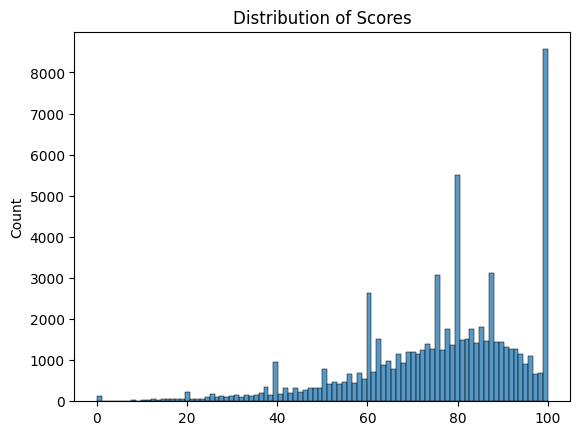

In [20]:
# Handle imbalanced data (if necessary)
# Check the distribution of target variable
sns.histplot(y)
plt.title('Distribution of Scores')
plt.show()


In [21]:
# Define sample weights inversely proportional to the score (lower scores get higher weights)
max_score = y.max()
min_score = y.min()
range_score = max_score - min_score + 1  # Adding 1 to avoid division by zero
sample_weights_full = (max_score - y + 1) / range_score  # Adding 1 to ensure no zero weights

# Split the data into training and testing sets
X_train, X_test, y_train, y_test, sample_weights_train, sample_weights_test = train_test_split(
    X, y, sample_weights_full, test_size=0.2, shuffle=True, random_state=42
)

In [22]:
# # Install the package
# !pip install imbalanced-learn

# from imblearn.over_sampling import SMOTE

# # Reshape X_train for SMOTER (flatten the sequences)
# X_train_flat = X_train.reshape((X_train.shape[0], X_train.shape[1]))

# smoter = SMOTE(random_state=42)
# X_resampled, y_resampled = smoter.fit_resample(X_train_flat, y_train)

# # Reshape X_resampled back to sequences for LSTM
# X_resampled_lstm = X_resampled.reshape((X_resampled.shape[0], sequence_length, 1))


In [23]:
# Reshape data for LSTM input
X_train_lstm = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_lstm = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [24]:
# # Build the LSTM model
# model = Sequential()
# model.add(LSTM(64, activation='relu', input_shape=(sequence_length, 1)))
# model.add(Dropout(0.2))
# model.add(Dense(1))

model = Sequential()
# First LSTM layer with return_sequences=True to stack more LSTM layers
model.add(LSTM(64, activation='relu', input_shape=(sequence_length, 1), return_sequences=True))
model.add(Dropout(0.2))

# Second LSTM layer without return_sequences since it's the last LSTM layer
model.add(LSTM(32, activation='relu'))
model.add(Dropout(0.2))

# Final Dense layer for regression output
model.add(Dense(1))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [25]:
# Compile the model with a custom loss function
def custom_loss(y_true, y_pred):
    # Higher weight for lower scores
    weights = tf.where(y_true < 40.0, 2.0, 1.0)
    return tf.reduce_mean(weights * tf.square(y_true - y_pred))

In [26]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mse')

In [27]:
# Train the LSTM model with sample weights
history = model.fit(
    X_train_lstm,
    y_train,
    sample_weight=sample_weights_train,
    epochs=100,
    batch_size=32,
    validation_split=0.1
)

Epoch 1/100
1662/1662 ━━━━━━━━━━━━━━━━━━━━ 18s 9ms/step - loss: 136.6494 - val_loss: 89.2710
Epoch 2/100
1662/1662 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - loss: 87.7017 - val_loss: 67.2122
Epoch 3/100
1662/1662 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - loss: 83.5733 - val_loss: 73.1013
Epoch 4/100
1662/1662 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - loss: 82.0189 - val_loss: 80.1069
Epoch 5/100
1662/1662 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - loss: 84.1413 - val_loss: 69.6523
Epoch 6/100
1662/1662 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - loss: 79.4456 - val_loss: 69.3037
Epoch 7/100
1662/1662 ━━━━━━━━━━━━━━━━━━━━ 21s 9ms/step - loss: 82.0666 - val_loss: 71.6569
Epoch 8/100
1662/1662 ━━━━━━━━━━━━━━━━━━━━ 20s 9ms/step - loss: 80.6786 - val_loss: 69.9743
Epoch 9/100
1662/1662 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - loss: 79.3854 - val_loss: 79.4951
Epoch 10/100
1662/1662 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - loss: 79.7325 - val_loss: 67.0562
Epoch 11/100
1662/1662 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - loss: 80.9736 - val

In [28]:
# Evaluate the LSTM model
# Predict on test set
y_pred = model.predict(X_test_lstm)

462/462 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step


In [29]:
# Check for NaN in X_train_lstm and X_test_lstm
print("NaN in X_train_lstm:", np.isnan(X_train_lstm).any())
print("NaN in X_test_lstm:", np.isnan(X_test_lstm).any())

# If NaN are present, consider imputation using SimpleImputer
!pip install scikit-learn
from sklearn.impute import SimpleImputer

X_train_lstm_2d = X_train_lstm.reshape(-1, X_train_lstm.shape[-1])  # Reshape to (num_samples, num_features)
X_test_lstm_2d = X_test_lstm.reshape(-1, X_test_lstm.shape[-1])

imputer = SimpleImputer(strategy='mean')  # Replace 'mean' with other strategies if needed
X_train_lstm_imputed = imputer.fit_transform(X_train_lstm_2d)
X_test_lstm_imputed = imputer.transform(X_test_lstm_2d)

# Reshape back to the original 3D shape after imputation
X_train_lstm = X_train_lstm_imputed.reshape(X_train_lstm.shape)
X_test_lstm = X_test_lstm_imputed.reshape(X_test_lstm.shape)

NaN in X_train_lstm: False
NaN in X_test_lstm: False


In [30]:
# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('LSTM Model Evaluation:')
print('Test MSE:', mse)
print('Test MAE:', mae)
print('Test R2 Score:', r2)

LSTM Model Evaluation:
Test MSE: 540.024538569773
Test MAE: 20.240631410765754
Test R2 Score: -0.5778158257323718


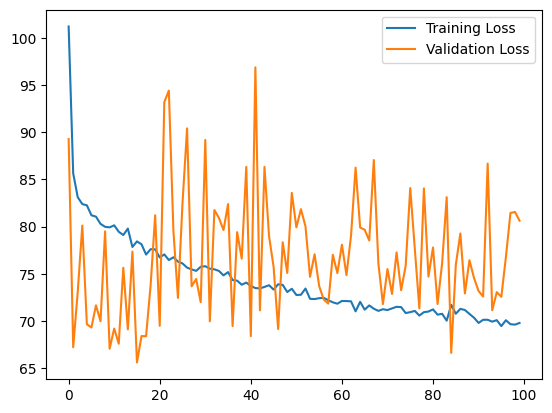

In [31]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()


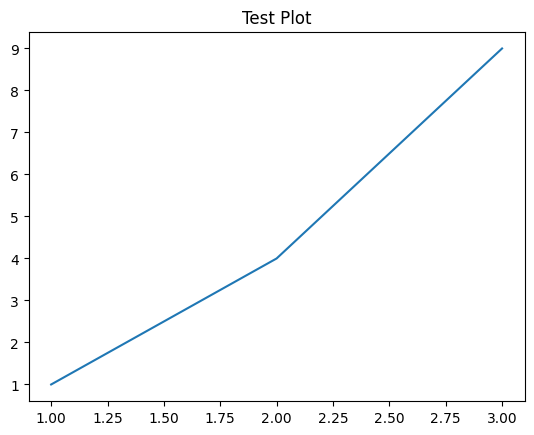

In [32]:
import matplotlib.pyplot as plt

plt.plot([1, 2, 3], [1, 4, 9])
plt.title('Test Plot')
plt.show()


In [33]:
# Save the trained LSTM model to an .h5 file
model.save('trained_assessment_marks_orediction_model.h5')
print("Model exported as trained_assessment_marks_orediction_model.h5")


Model exported as trained_assessment_marks_orediction_model.h5


In [34]:
from tensorflow.keras.models import load_model
import tensorflow as tf

# Re-define the custom loss function
def custom_loss(y_true, y_pred):
    weights = tf.where(y_true < 40.0, 2.0, 1.0)
    return tf.reduce_mean(weights * tf.square(y_true - y_pred))

# Load the model with the custom loss and use 'MeanSquaredError' from tf.keras.losses
model = load_model(
    '/content/drive/MyDrive/FYP Models/trained_assessment_marks_orediction_model.h5',
    custom_objects={'custom_loss': custom_loss, 'mse': tf.keras.losses.MeanSquaredError()}
)


In [35]:
# Predict on test data
y_pred = model.predict(X_test_lstm)

462/462 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


In [ ]:
# Calculate evaluation metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [37]:
# Compute Mean Squared Error (MSE), Mean Absolute Error (MAE), and R² Score
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('LSTM Model Evaluation:')
print('Test MSE:', mse)
print('Test MAE:', mae)
print('Test R2 Score:', r2)

LSTM Model Evaluation:
Test MSE: 523.0783020334508
Test MAE: 19.832597788820355
Test R2 Score: -0.5283031864281882


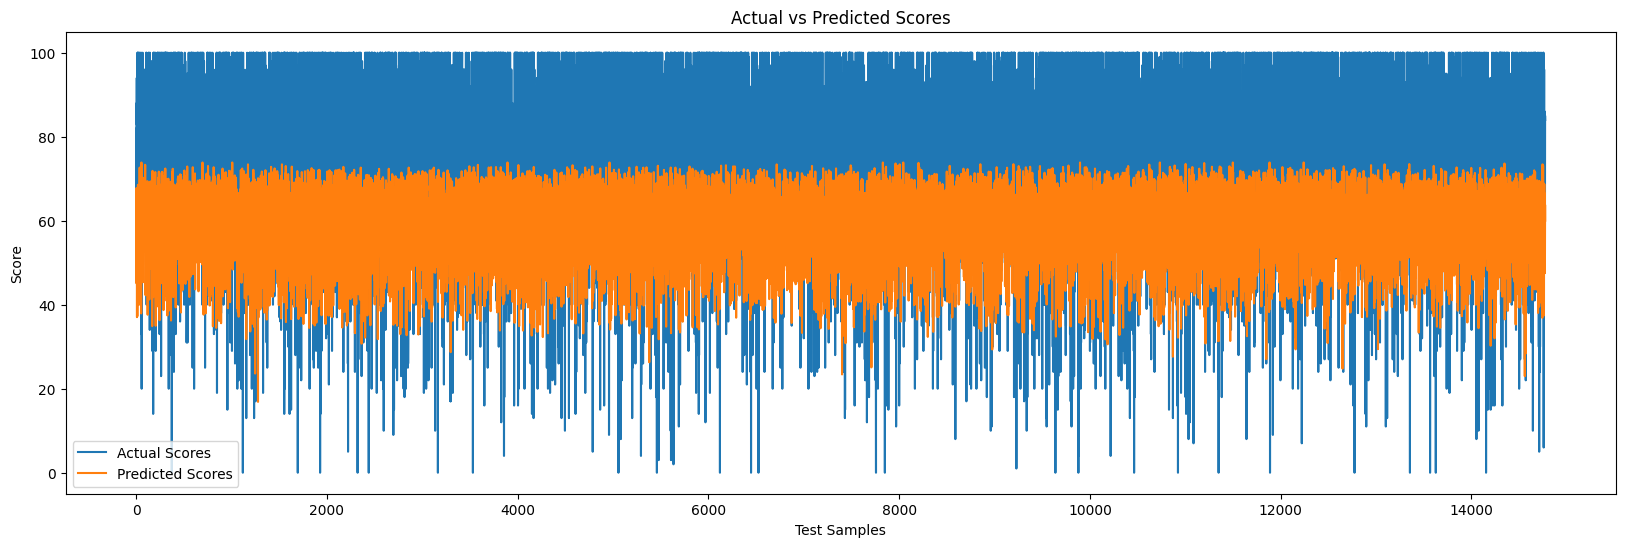

In [38]:
# Visualize Actual vs Predicted Scores
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 6))
plt.plot(y_test, label='Actual Scores')
plt.plot(y_pred, label='Predicted Scores')
plt.xlabel('Test Samples')
plt.ylabel('Score')
plt.title('Actual vs Predicted Scores')
plt.legend()
plt.show()

In [39]:
# Test an individual sequence
sample_index = 0
sample_sequence = X_test_lstm[sample_index]

In [40]:
# Reshape for prediction
sample_sequence = np.expand_dims(sample_sequence, axis=0)
predicted_score = model.predict(sample_sequence)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


In [41]:
# print values for index  = 0
print(f"Predicted Score for sample {sample_index}: {predicted_score[0][0]}")
print(f"Actual Score for sample {sample_index}: {y_test[sample_index]}")

Predicted Score for sample 0: 45.481605529785156
Actual Score for sample 0: 49.0
